In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

In [8]:
data = np.genfromtxt('winequality-white.csv',delimiter=';')[1:]
print(data.shape)

(4898, 12)


In [9]:
X = data[:,:11]
y = data[:,11]
print(X.shape, y.shape)

(4898, 11) (4898,)


In [10]:
def normalize(X):
    X_flat = flatten(X)
    mu = X_flat.mean(axis=0)
    return [x - mu for x in X]
def flatten(X):
    X_flat = []

    for x in X:
        X_flat += list(x)

    return np.array(X_flat)

In [11]:
class ModelCheckpoint:
    def __init__(self, metric_fn, data_generator, num_sampled=10000):
        self.best_model = None
        self.best_metric = -float("inf")
        self.metric_fn = metric_fn
        self.num_sampled = num_sampled
        self.data_generator = data_generator
    
    def __call__(self, model):
        X_val, y_val = self.data_generator(self.num_sampled)
        metric = self.metric_fn(y_val, model.predict(X_val))
        
        if metric > self.best_metric:
            self.best_metric, self.best_model = metric, model   
            print("[ModelCheckpoint] New best model with %.3f validation accuracy" % metric)
        else:
            print("validation: %.3f accuracy" % metric)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
X = normalize(X)
model = LogisticRegression(fit_intercept=False)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
import random as rand
subsets = []
for i in range(100):        
    subsets.append(rand.sample(list(data), 10))
subsets = np.asarray(subsets)
subsets.shape

(100, 10, 12)

In [15]:
# Detailed in the paper
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

In [16]:
model2 = LogisticRegression(fit_intercept=False,C=2, penalty='l2')
model2.fit(X, y)

def my_loss(preds, ys, delta = 0):
    correct = ys.argmax()
    score_correct = preds[correct]

    loss = 0
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)
    return loss

Computing losses...


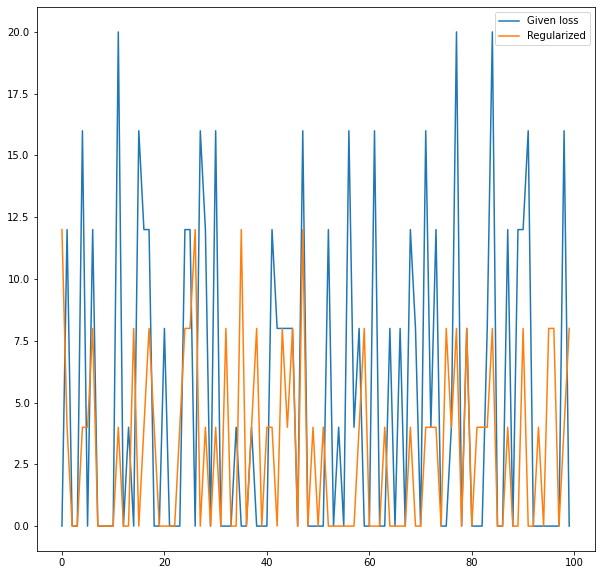

In [17]:
loss = []
reg_loss = []
print("Computing losses...")
for subset in subsets:
    preds = model.predict(subset[:, :11])
    my_preds = model2.predict(subset[:, :11])
    score = np.argmax(preds)
    best_wine = subset[score][11]
    # print("The best wine is:",best_wine)
    loss.append(svm_loss(preds, subset[:,11]))
    reg_loss.append(my_loss(my_preds, subset[:,11]))
    # print("Loss from Paper:", svm_loss(preds, subset[:,11]))
    # print("Regularized:",my_loss(my_preds, subset[:,11]))

plt.figure(figsize=(10,10))
plt.plot(loss, label="Given loss")
plt.plot(reg_loss, label="Regularized")
plt.legend()
plt.show()

In [18]:
class GradientDescent:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def __call__(self, gradient):
        return self.learning_rate * gradient

In [56]:
class SVMRanking:
    def __init__(self, delta, X, y):
        self.delta = delta
        self.X = X
        self.y = y
        self.lamda = 2
        
    def fit(self,optimizer, num_iterations=10, callbacks=[]):
        self.W = np.ones_like(11)
        for j in range(num_iterations):
            # X, y = data_generator(4000)
            preds = self.predict(X)
            gradient = np.zeros(11)

            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                print(correct, pi)
                score_correct = pi[correct]

                for i, predicted_score in enumerate(pi):
                    gradient -= (xi[i] * max(0, predicted_score + self.delta - score_correct) + (2 * self.lamda * self.W))
            
            gradient /= len(X)
            
            # loss = np.mean([svm_loss(pi, yi) for pi, yi in zip(self.predict(X), y)])
            # accuracy = rank_accuracy(y, model.predict(X))
            
            # print("[%d/%d] training: %.5f loss, %.3f accuracy" % (j + 1, num_iterations, loss, accuracy))
            
            self.W = np.add(self.W, optimizer(gradient))
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W.T)
            preds.append(scores)
        
        return preds

In [57]:
np.random.seed(0)
model = SVMRanking(0., X[:10], y)
model.fit(optimizer=GradientDescent(30.),
          num_iterations=48)

-6.68268707]
0 [-12.53268707 -18.17268707 -18.14268707 -13.03268707 -18.38668707
  15.56731293  97.56731293 -17.44044707 -15.19268707 -18.02268707
  -7.03268707]
0 [-13.23268707 -18.13268707 -18.09268707 -16.93268707 -18.39468707
  -0.43268707  77.56731293 -17.44326707 -14.87268707 -17.95268707
  -5.43268707]
0 [-12.03268707 -18.11268707 -18.18268707 -13.43268707 -18.37768707
   9.56731293 119.56731293 -17.44097707 -15.16268707 -17.93268707
  -6.03268707]
0 [-11.83268707 -18.24268707 -18.18268707 -17.23268707 -18.38068707
  15.56731293 162.56731293 -17.43916707 -15.13268707 -18.01268707
  -9.03268707]
0 [-11.63268707 -18.16268707 -18.13268707  -5.43268707 -18.38568707
  50.56731293 141.56731293 -17.43563707 -15.27268707 -17.93268707
  -8.83268707]
0 [-11.63268707 -18.16268707 -18.13268707  -5.43268707 -18.38568707
  50.56731293 141.56731293 -17.43563707 -15.27268707 -17.93268707
  -8.83268707]
0 [-11.63268707 -18.16268707 -18.13268707  -5.43268707 -18.38568707
  50.56731293 141.5673129

IndexError: invalid index to scalar variable.

In [39]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)